# Environmental and Racial justice in NYC:
### Does minorities and low income communities have less access to green spaces and more exposure to air pollution?

### 1. Introduction
Environmental inequality in the U.S. has a long history closely linked to physical community segregation and unequal distribution of pollution sources and environmental
amenities. This includes redlining, discriminatory zoning, and other practices that have resulted in the concentration of low-income and minority communities. Even though, economically speaking, these low income communities sort themselves into these areas, as urban planners, it is also our responsibility to ensure that these communities are not being disproportionately affected by environmental hazards.

These environmental hazards include exposure to air pollution and lack of access to green spaces or trees. Exposure to air pollution has been linked to many health problems, including asthma, heart disease, and lung cancer. On the other hand, access to green spaces has been linked to better mental health, lower stress levels, and lower rates of depression.

This study aims at identify the pattern of environmental inequality in NYC, if any.

### 2. Data collection, preparation, and cleaning
In this study, we will be using the following datasets:
1. ACS 2018 5-year estimates to get the demographic data of NYC census tracts

2. NYC 2018 tree census data to get the tree count, density, as a proxy of the greenary amenities in NYC

3. Google Street View API to get the street view images of NYC census tracts - and calculate the GVI based on the images

4. Air quality data from NYC Open Data portal to assess the air quality in NYC census tracts

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# acs data
acs = pd.read_csv('ACS.csv')
acs.head()

/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_31966/3299272173.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A10065_001,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
0,36005000100,"Census Tract 1, Bronx County, New York",ACSSF,ny,140,0,3608,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,"Census Tract 2, Bronx County, New York",ACSSF,ny,140,0,3609,NaN,NaN,NaN,...,833,450,1340,228,384,354,167,89,0,118
2,36005000400,"Census Tract 4, Bronx County, New York",ACSSF,ny,140,0,3610,NaN,NaN,NaN,...,1056,727,2110,402,602,509,426,121,50,0
3,36005001600,"Census Tract 16, Bronx County, New York",ACSSF,ny,140,0,3611,NaN,NaN,NaN,...,1032,738,2153,456,630,338,329,281,79,40
4,36005001901,"Census Tract 19.01, Bronx County, New York",ACSSF,ny,140,0,3612,NaN,NaN,NaN,...,398,208,784,259,282,74,105,39,12,13


For ACS data, we would like to aggregate the block group level data to the census tract level to match the other datasets. We will be using the following variables:
1. __Race: Hispanic or Latino by Race (Collapsed Version)__
         Universe:  Total Population
         Name:      B04001
         Variables:
            B04001_001:   Total Population:
            B04001_002:      Not Hispanic or Latino:
            B04001_003:         White Alone
            B04001_004:         Black or African American Alone
            B04001_005:         American Indian and Alaska Native Alone
            B04001_006:         Asian Alone
            B04001_007:         Native Hawaiian and Other Pacific Islander Alone
            B04001_008:         Some Other Race Alone
            B04001_009:         Two or More Races
            B04001_010:      Hispanic or Latino


2. __Income: Household Income (In <DollarYear> Inflation Adjusted Dollars) (Collapsed Version)__
         Universe:  Households
         Name:      B14001
         Variables:
            B14001_001:   Households:
            B14001_002:      Less than $25,000
            B14001_003:      $25,000 to $49,999
            B14001_004:      $50,000 to $74,999
            B14001_005:      $75,000 to $99,999
            B14001_006:      $100,000 or More

3. __Rent burden: Residents Paying More Than 30% or at least 50% of Income on Rent__
          Universe:  Renter-Occupied Housing Units
          Name:      B18002
          Variables:
             B18002_001:   Renter-Occupied Housing Units:
             B18002_002:      30 to 49 Percent
             B18002_003:      50 percent or More

In [2]:
# cleanning the acs data, and to census tract level
acs_filtered = pd.DataFrame()
acs_filtered['Geo_FIPS'] = acs['Geo_FIPS'].astype(str)
acs_filtered['Geo_QName'] = acs['Geo_QName']
# -----
# race info
"""
Hispanic or Latino by Race (Collapsed Version)
         Universe:  Total Population
         Name:      B04001
         Variables:
            B04001_001:   Total Population:
            B04001_002:      Not Hispanic or Latino:
            B04001_003:         White Alone
            B04001_004:         Black or African American Alone
            B04001_005:         American Indian and Alaska Native Alone
            B04001_006:         Asian Alone
            B04001_007:         Native Hawaiian and Other Pacific Islander Alone
            B04001_008:         Some Other Race Alone
            B04001_009:         Two or More Races
            B04001_010:      Hispanic or Latino
"""
acs_filtered['Total_Pop'] = acs['SE_B04001_001']
acs_filtered['White_Pct'] = acs['SE_B04001_003'] / acs['SE_B04001_001']
acs_filtered['Black_Pct'] = acs['SE_B04001_004'] / acs['SE_B04001_001']
acs_filtered['Asian_Pct'] = acs['SE_B04001_006'] / acs['SE_B04001_001']
acs_filtered['Hispanic_Pct'] = acs['SE_B04001_010'] / acs['SE_B04001_001']
# ----- income
"""
      6. Household Income (In <DollarYear> Inflation Adjusted Dollars) (Collapsed Version)
         Universe:  Households
         Name:      B14001
         Variables:
            B14001_001:   Households:
            B14001_002:      Less than $25,000
            B14001_003:      $25,000 to $49,999
            B14001_004:      $50,000 to $74,999
            B14001_005:      $75,000 to $99,999
            B14001_006:      $100,000 or More


      7. Median Household Income (In <DollarYear> Inflation Adjusted Dollars)
         Universe:  Households
         Name:      A14006
         Variables:
            A14006_001:   Median Household Income (In 2020 Inflation Adjusted Dollars)
"""
acs_filtered['Median_hh_Income'] = acs['SE_A14006_001']
# ----- rent burden
"""
      11. Residents Paying More Than 30% or at least 50% of Income on Rent
          Universe:  Renter-Occupied Housing Units
          Name:      B18002
          Variables:
             B18002_001:   Renter-Occupied Housing Units:
             B18002_002:      30 to 49 Percent
             B18002_003:      50 percent or More
"""
acs_filtered['Rent_30_50pct'] = acs['SE_B18002_002'] / acs['SE_B18002_001']
acs_filtered['Rent_50+pct'] = acs['SE_B18002_003'] / acs['SE_B18002_001']

In [3]:
acs_filtered.head()

,Geo_FIPS,Geo_QName,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct
0,36005000100,"Census Tract 1, Bronx County, New York",6600,0.123788,0.490000,0.025909,0.350758,NaN,NaN,NaN
1,36005000200,"Census Tract 2, Bronx County, New York",4167,0.018479,0.235181,0.027598,0.706263,68000.0,0.200355,0.329787
2,36005000400,"Census Tract 4, Bronx County, New York",5684,0.065271,0.169775,0.015306,0.729768,93155.0,0.244207,0.165775
3,36005001600,"Census Tract 16, Bronx County, New York",5917,0.038702,0.335643,0.010647,0.563630,34766.0,0.375396,0.164731
4,36005001901,"Census Tract 19.01, Bronx County, New York",1910,0.135602,0.319372,0.000000,0.538743,61711.0,0.185567,0.293814


---
The tree-sensus data contains point data of the trees in NYC. Using spatial join, we count the number of tree and tree density in each block group.


For tree census data, we would like to aggregate the block level data to the census tract level to match the other datasets.

In [4]:
# tree density
# notice that this is at block group level -> FIPS = FIPS[:-1]
tree = pd.read_csv('tree_density.csv')
tree_filtered = pd.DataFrame()
tree_filtered['Geo_FIPS'] = tree['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
tree_filtered['tree_density'] = tree['NYC_Block_group_tree_temp_pollution_Tree_density']
tree_filtered['tree_num'] = tree['NYC_Block_group_tree_temp_pollution_Number_of_trees']
tree_filtered.head()

,Geo_FIPS,tree_density,tree_num
0,36005017500,0.000149,38
1,36005014100,0.000048,29
2,36005014500,0.000103,52
3,36005007500,0.000194,228
4,36005041800,0.000060,91


---
The Green View Index (GVI) is calculated from the Google Street View (GSV) images using Semantic Image Segmentation. GVI is a representation of the residents’ eye-level
perception of urban greenery.
We used the road network and boundary shapefile of the City provided by NYC Open Data as the input to determine which points to sample GVI from. Using the Python libraries
Fiona and Shapely, we created 140,000 points along the street network with a sampling distance of 200 meters. To make the input points more accurately reflect ordinary residents’ perceived
greenness, and to meet our constraints in computational power and budget, we filtered out the points that are less accessible: points on highways or in tunnels were removed, for example.

We retrieved 496,158 images from 82,693 sampling points, and averaged the GVIs to each census tract.

In [5]:
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))


# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])

def seg(img):
    pil_image = PIL.Image.open(img).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    return pred
    #=====================Visualization=======================================#
    #visualize_result(img_original, pred)


    # Top classes in answer
    #predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
    #for c in predicted_classes[:10]:
        #visualize_result(img_original, pred, c)

def GVI_calculation(img):
    resolution = 400*400
    veg_code = {
        'tree' : 4,
        'grass' : 9,
        'palm' : 72}
    pred = seg(img)
    pixel_count = 0
    for i in greenIndex.values():
        pixel_count += len(np.where(pred == i)[0]) # accumulate pixel count
    GVI_Pct = pixel_count/resolution*100
    return GVI_Pct



ModuleNotFoundError: No module named 'torch'

Sample GSV images fetched

![](pic/1.jpg)


Predicted vegetation result created from the MIT ADE20K scene parsing dataset

![](pic/2.jpg)

In [6]:
# GVI
gvi = pd.read_csv('GVI.csv')
gvi_filtered = pd.DataFrame()
gvi_filtered['Geo_FIPS'] = gvi['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
gvi_filtered['GVI'] = gvi['mean_greenview_1']
gvi_filtered.head()

,Geo_FIPS,GVI
0,36005017500,15.503791
1,36005014100,13.517106
2,36005014500,18.115964
3,36005007500,20.787891
4,36005041800,15.575710


---
Air quality data includes the concentration of nitrogen dioxide (NO2), fine particulate matter (PM2.5), nitric oxide (NO), and ozone (O3).

Unfortunately, due to the low spatial resolution of the pollution data, we were only able to obtain averages for 4,065 block groups out of the 6,287 land census block groups in the City.


In [7]:
# air quality
pollution_filtered = pd.DataFrame()
pollution_filtered['Geo_FIPS'] = gvi['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
pollution_filtered['PM2.5'] = gvi['NYC_Block_group_tree_temp_pollution_Mean_PM2']
pollution_filtered.head()

,Geo_FIPS,PM2.5
0,36005017500,6.074496
1,36005014100,6.073939
2,36005014500,6.198496
3,36005007500,6.040218
4,36005041800,5.950134


## Data aggregation
We would like to plot the data for further investigation. To do so, we need to merge the dataframes together. We will use the Geo_FIPS column as the key to merge the dataframes.
We also included the geometry column from the census tract data to plot the data on the map.

In [55]:
# merge data

# census tract
ct = gpd.read_file('ct.json')

aggregate = gpd.GeoDataFrame()
aggregate['geometry'] = ct['geometry']
aggregate['Geo_FIPS'] = ct['GEOID'].astype(str)
aggregate['BoroName'] = ct['BoroName']
aggregate['NTAName'] = ct['NTAName']
# -----
# ACS data
aggregate = aggregate.merge(acs_filtered, on='Geo_FIPS')
# -----
# tree density
aggregate = aggregate.merge(tree_filtered, on='Geo_FIPS')
# -----
# gvi
aggregate = aggregate.merge(gvi_filtered, on='Geo_FIPS')
# -----
# air quality
aggregate = aggregate.merge(pollution_filtered, on='Geo_FIPS')
aggregate.head()

,geometry,Geo_FIPS,BoroName,NTAName,Geo_QName,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct,tree_density,tree_num,GVI,PM2.5
0,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",36061000100,Manhattan,The Battery-Governors Island-Ellis Island-Libe...,"Census Tract 1, New York County, New York",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,NaN,5.743412
1,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,1.638854,6.532890
2,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,1.638854,NaN
3,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,17.656432,6.532890
4,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,17.656432,NaN


In [59]:
# count nas
aggregate.isna().sum()
# fill na using the mean of the closest 5 neighbors
# aggregate = aggregate.fillna(aggregate.iloc[:, 5:].mean(axis=1))
# drop na
aggregate = aggregate.dropna()

In [60]:
aggregate.shape

(1566, 17)

In [58]:
# drop duplicate geo_FIPS
aggregate = aggregate.drop_duplicates(subset=['Geo_FIPS'])
aggregate.shape

(2033, 17)

# TODO - calculate the segregation index

# 3. Exploratory Data Analysis

# 3.1 Correlation between variables

<AxesSubplot: >

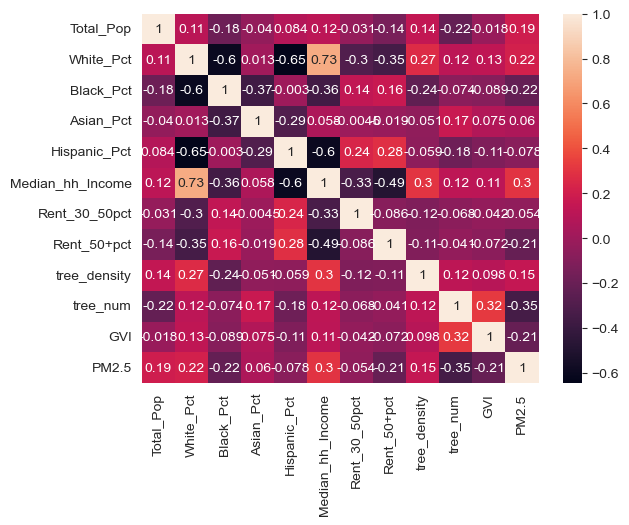

In [9]:
# cov matrix plot
sns.heatmap(aggregate.corr(), annot=True)

Based on the correlation matrix, we can see that median household income is highly correlated with the percentage of white population, and negatively correlated with other minority groups.
Lower income families are also more likely to have a higher burden on Rents, indicated by the negative correlation between median household income and percentage of households with high rental burden.

Comparing the demographic data with environmental indicators, it is interesting to see that while environmental amenities follows the income, the air quality does not.


# 3.2 Baseline models predicting median household income

In this part, we will experiment different models to see the relationship between median household income (y) using the environmental indicators. We will use the following models:
- Linear Regression
- Random Forest

In [48]:
# baseline models
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

y = aggregate['Median_hh_Income']
X = aggregate[['tree_density', 'tree_num', 'GVI', 'PM2.5']]
print(X.columns)

# linear regression
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

Index(['tree_density', 'tree_num', 'GVI', 'PM2.5'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Median_hh_Income   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     81.76
Date:                Mon, 08 May 2023   Prob (F-statistic):           4.53e-63
Time:                        11:13:04   Log-Likelihood:                -18481.
No. Observations:                1566   AIC:                         3.697e+04
Df Residuals:                    1561   BIC:                         3.700e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.116e+04   8767.495     -8.116      0.000   -8.84e+04    -5.4e+04
tree_density  3.575e+07   1.73e+07      2.063      0.039    1.75e+06    6.97e+07
tree_num        82.2712      8.339      9.866      0.000      65.914      98.628
GVI            462.0171    146.624      3.151      0.002     174.416     749.618
PM2.5         2.029e+04   1277.364     15.882      0.000    1.78e+04    2.28e+04
==============================================================================
Omnibus:                      302.046   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              839.789
Skew:                           0.999   Prob(JB):                    4.39e-183
Kurtosis:                       5.980   Cond. No.                     3.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot: ylabel='Median_hh_Income'>

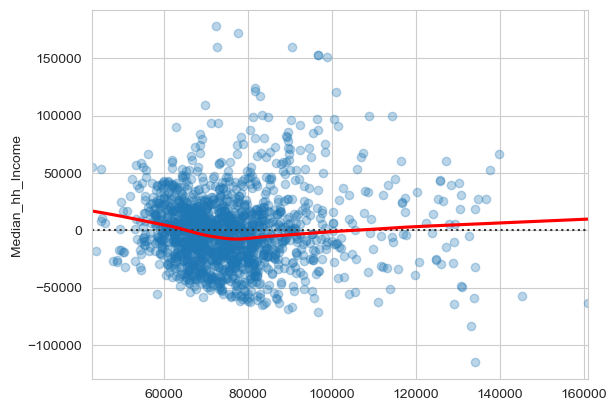

In [50]:
# plot the residuals
sns.residplot(x = model.fittedvalues, y = y, lowess=True, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.3})

The residuals plot shows that the linear regression model is not a good fit for the data, and indicate a possibility of spatial autocorrelation.

# 4 Spatial Analysis
## 4.1 Spatial Distribution of variables
Here, we plot the spatial distribution of the variables to provide an overview of the data.

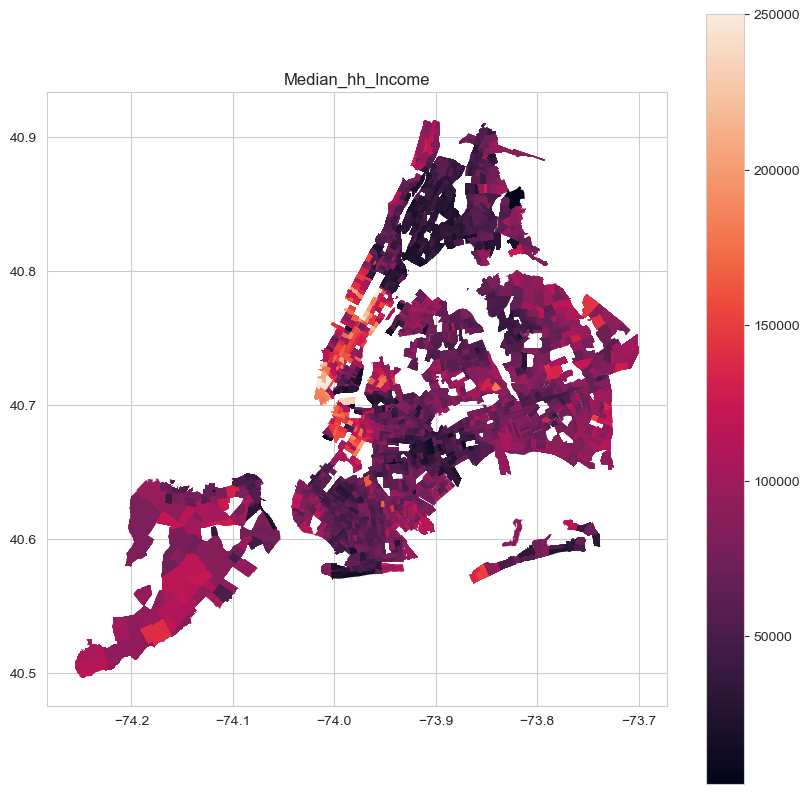

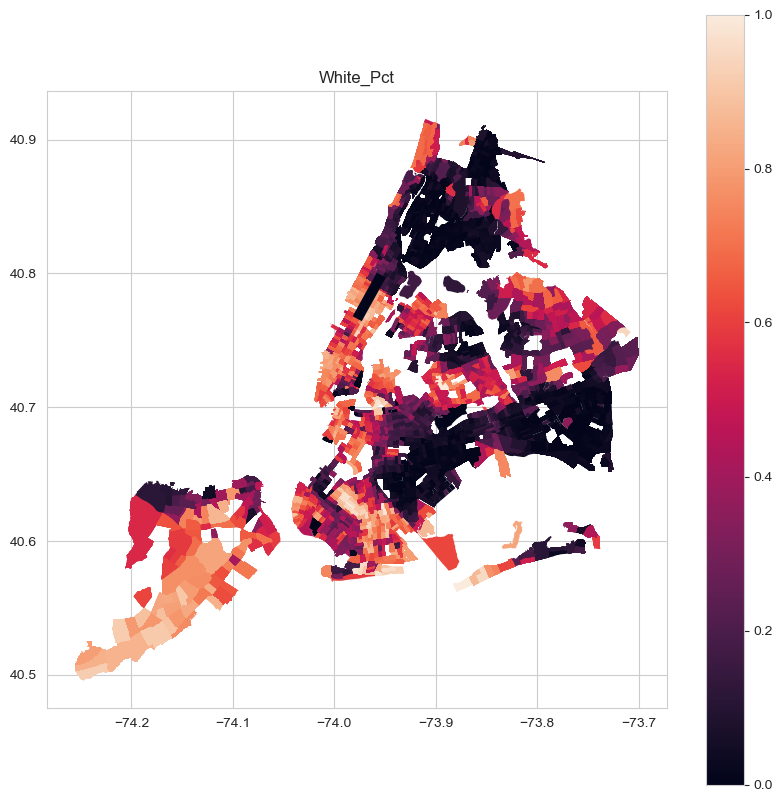

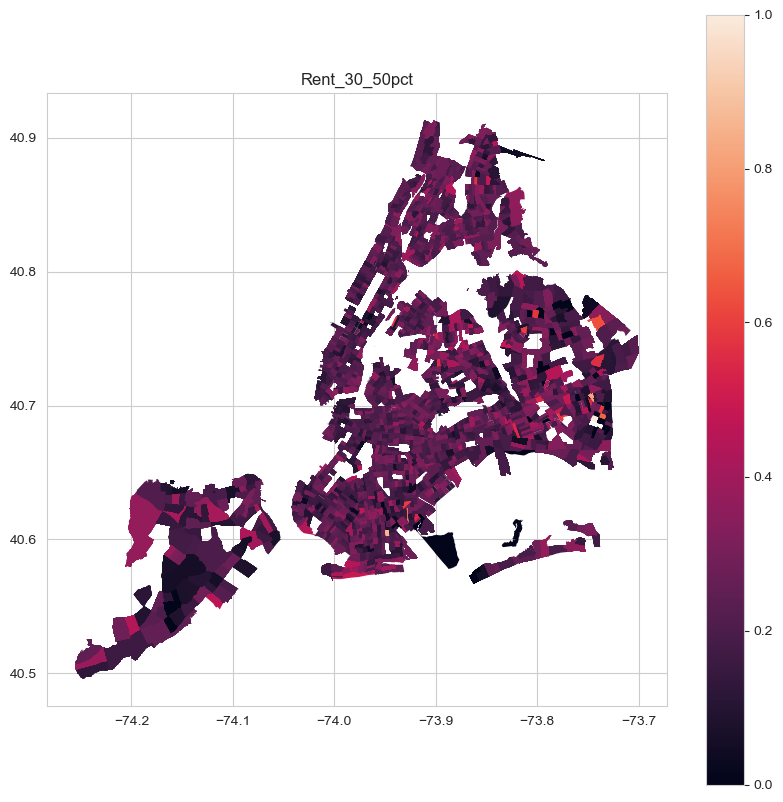

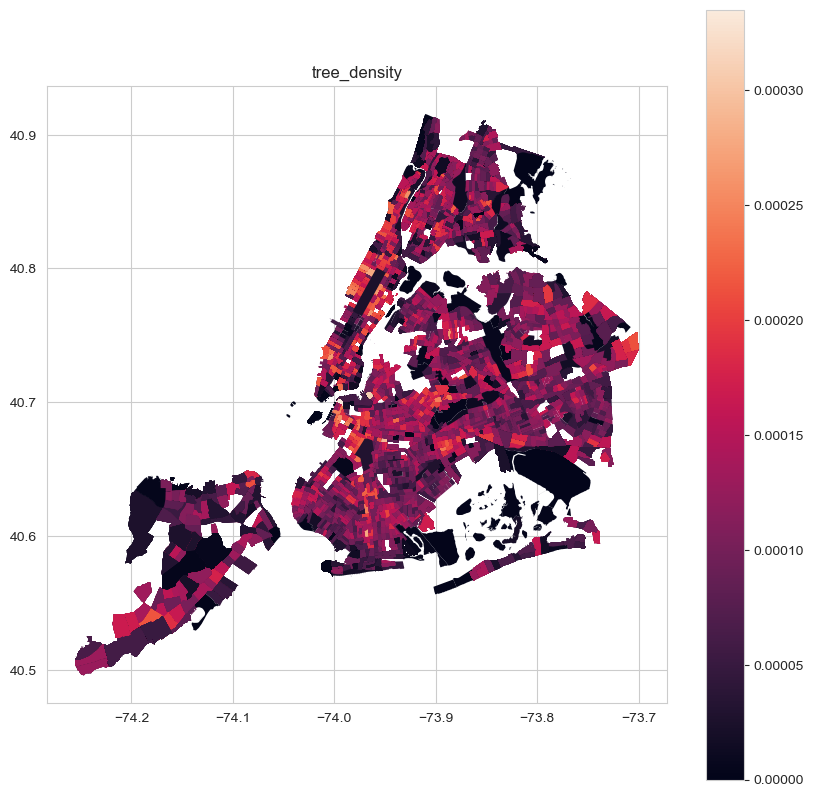

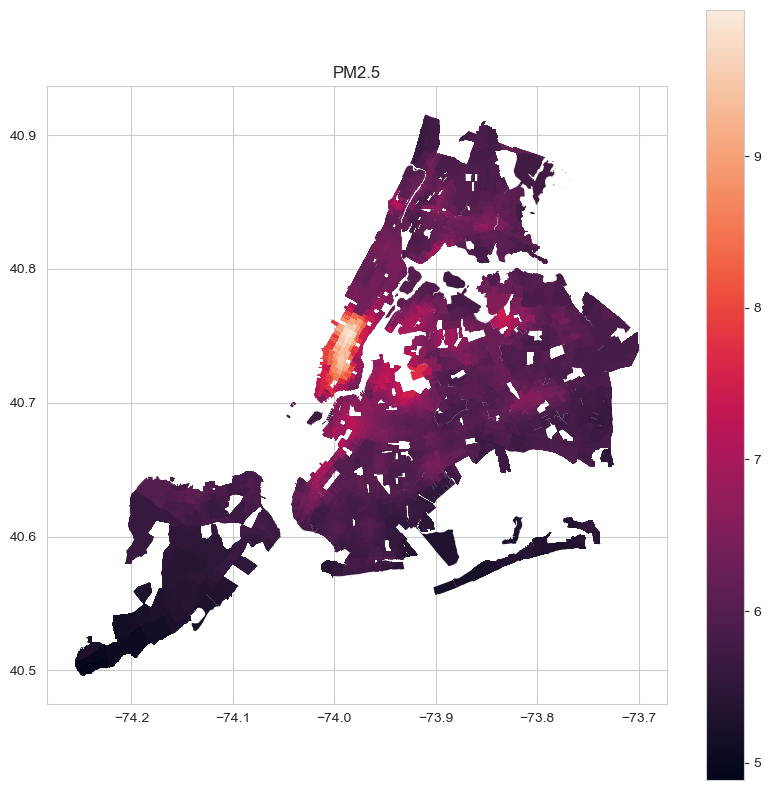

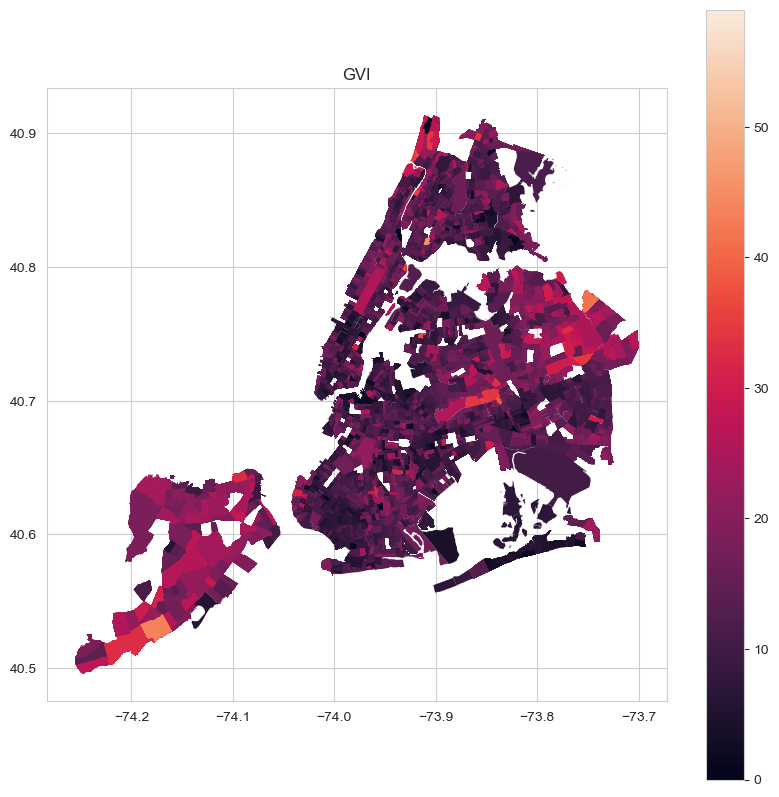

In [56]:
# choropleth map
variables_interest = ['Median_hh_Income','White_Pct', 'Rent_30_50pct', 'tree_density','PM2.5', 'GVI']
# visualize these variables of interest
for i, var in enumerate(variables_interest):
    aggregate.plot(column=var, legend=True, figsize=(10,10), linewidth = 0)
    # title
    plt.title(var)

# 4.2 Spatial Autocorrelation - Moran's I


In [52]:
# moran's I
from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from pysal.lib import weights

# calculate moran's I
w = weights.distance.KNN.from_dataframe(aggregate, k=5)

moran = Moran(aggregate['Median_hh_Income'], w)
moran.I


0.6268429197571551

In [53]:
moran = Moran(aggregate['Median_hh_Income'], w)
moran.I

0.6268429197571551

(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.63', ylabel='Density'>,
        <AxesSubplot: title={'center': 'Moran Scatterplot (0.63)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

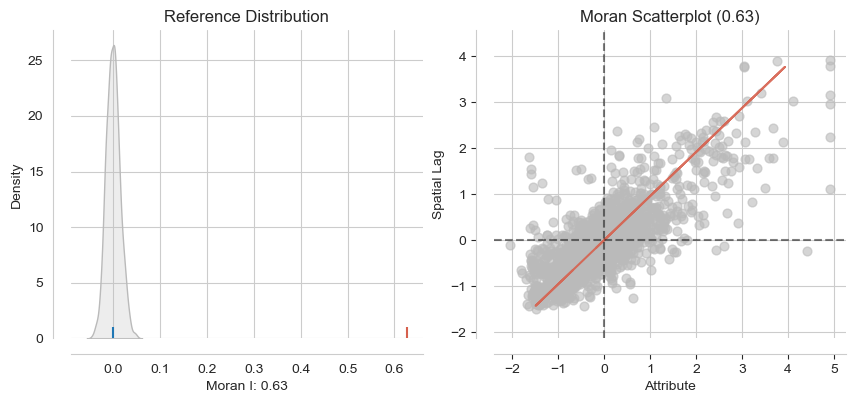

In [54]:
# plot moran's I
plot_moran(moran, zstandard=True, figsize=(10,4))

White_Pct 0.8058897244204171
Rent_30_50pct 0.03744359888595829
tree_density 0.2691847292647002
PM2.5 0.9644127960580493
GVI 0.41025450585916573


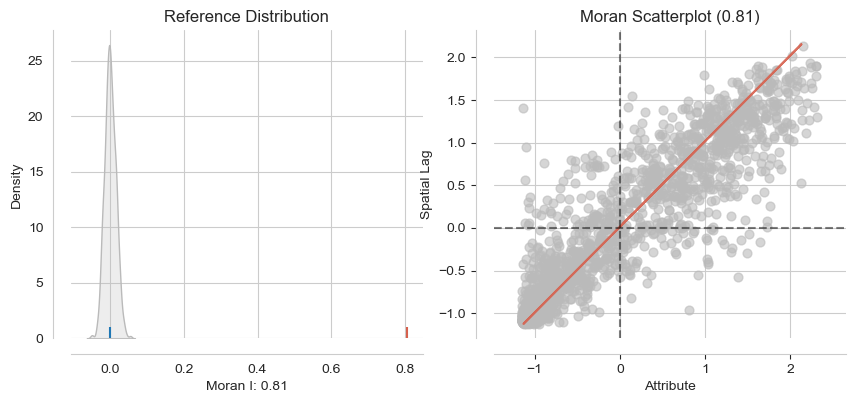

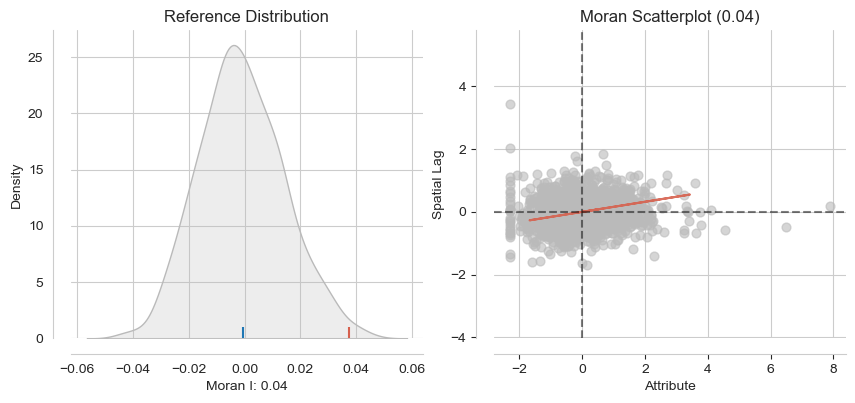

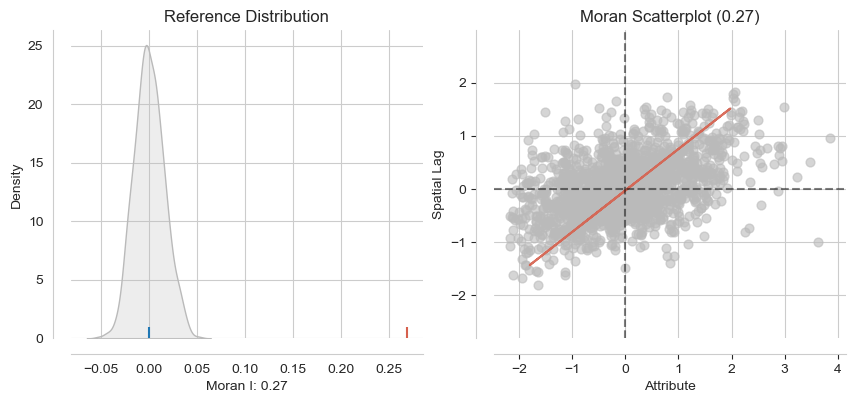

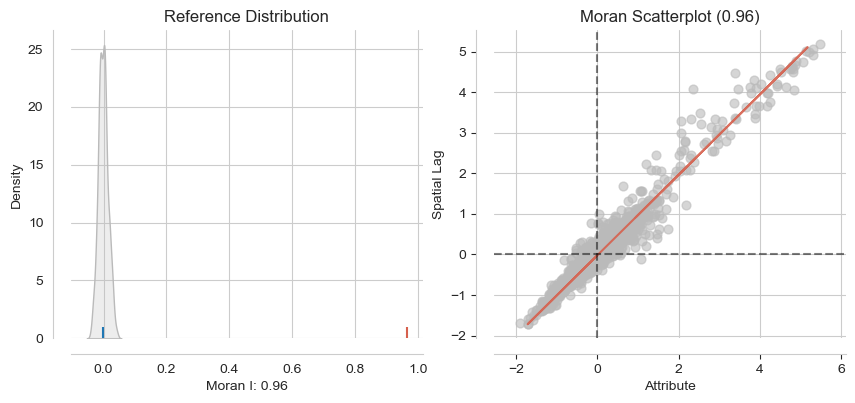

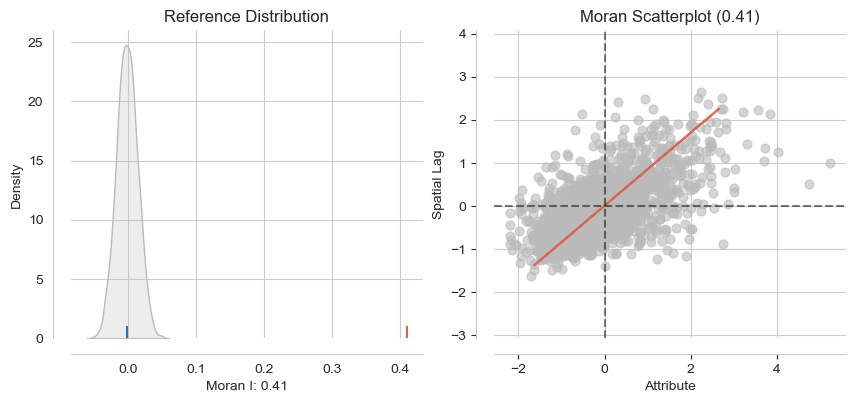

In [62]:
# other variables of interest
variables_interest = ['White_Pct', 'Rent_30_50pct', 'tree_density','PM2.5', 'GVI']
for var in variables_interest:
    moran = Moran(aggregate[var], w)
    print(var, moran.I)
    plot_moran(moran, zstandard=True, figsize=(10,4))b

# 4.3 Regionalization
Known that there is spatial autocorrelation in the data, we will use regionalization to group the census tracts into clusters based on the median household income, and other variables of interest.


<AxesSubplot: >

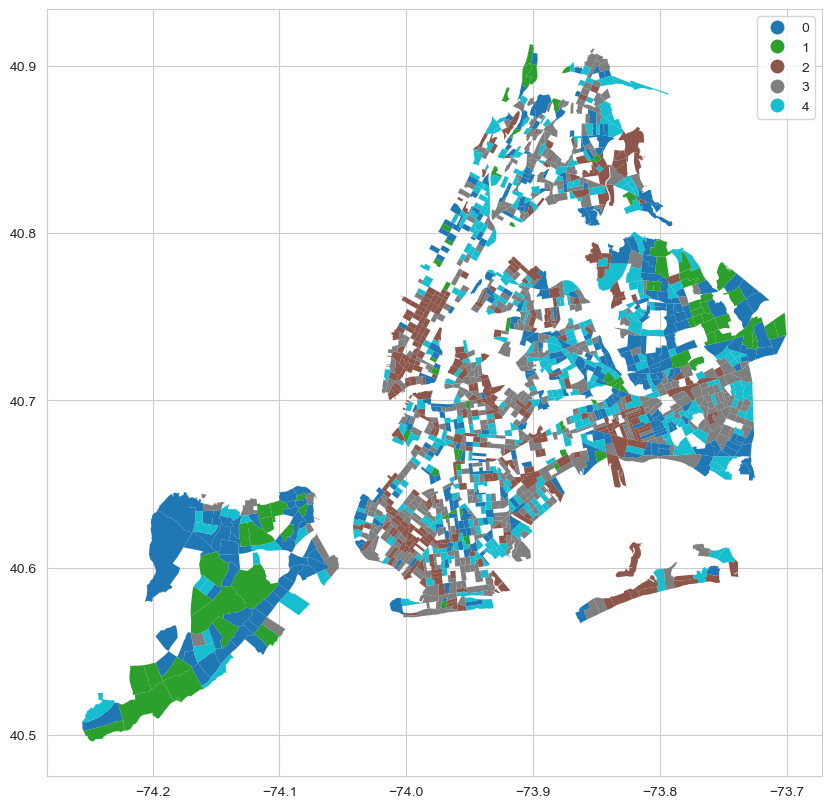

In [83]:
# regionalization - agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model.fit(aggregate[['Rent_30_50pct', 'tree_density','PM2.5', 'GVI']])
aggregate['cluster_agg5'] = model.labels_
aggregate['cluster_agg5'].value_counts()

# plot the clusters
aggregate.plot(column='cluster_agg5', categorical = True, legend=True, figsize=(10,10), linewidth = 0)



<AxesSubplot: >

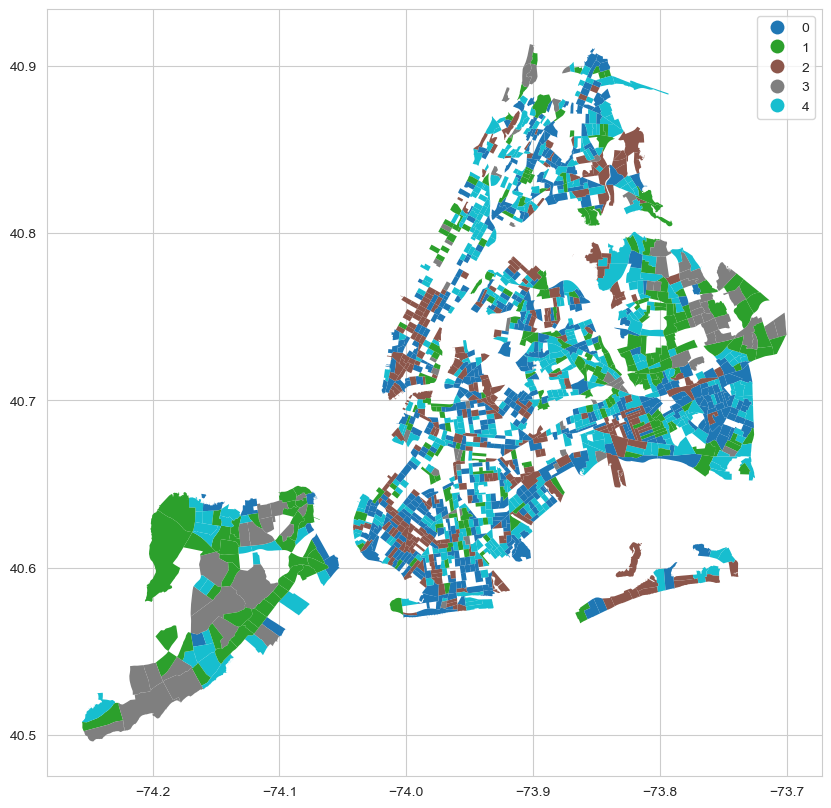

In [86]:
# knn clustering
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5)
model.fit(aggregate[['tree_density','PM2.5', 'GVI']])
aggregate['cluster_knn5'] = model.labels_
aggregate['cluster_knn5'].value_counts()

# plot the clusters
aggregate.plot(column='cluster_knn5', categorical = True, legend=True, figsize=(10,10), linewidth = 0)

In [84]:
# linear regression including the clusters
y = aggregate['Median_hh_Income']
# get dummies
aggregate['cluster_agg5'] = aggregate['cluster_agg5'].astype('category')
aggregate['cluster_knn5'] = aggregate['cluster_knn5'].astype('category')
X = pd.get_dummies(aggregate[['tree_density', 'tree_num', 'GVI', 'PM2.5', 'cluster_agg5']])

# linear regression
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Median_hh_Income   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     42.03
Date:                Mon, 08 May 2023   Prob (F-statistic):           3.57e-61
Time:                        13:13:11   Log-Likelihood:                -18477.
No. Observations:                1566   AIC:                         3.697e+04
Df Residuals:                    1557   BIC:                         3.702e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.476e+04   8756.165     -7.396      0.000   -8.19e+04   -4.76e+04
tree_density    4.276e+07   1.76e+07      2.423      0.016    8.14e+06    7.74e+07
tree_num          80.7692      8.406      9.609      0.000      64.282      97.257
GVI             1229.3578    446.192      2.755      0.006     354.156    2104.559
PM2.5            1.94e+04   1324.692     14.643      0.000    1.68e+04     2.2e+04
cluster_agg5_0 -1.887e+04   3464.750     -5.445      0.000   -2.57e+04   -1.21e+04
cluster_agg5_1  -1.98e+04   7487.031     -2.644      0.008   -3.45e+04   -5109.855
cluster_agg5_2 -2850.4652   4352.040     -0.655      0.513   -1.14e+04    5686.012
cluster_agg5_3 -1.064e+04   2377.528     -4.477      0.000   -1.53e+04   -5979.898
cluster_agg5_4 -1.261e+04   2119.145     -5.950      0.000   -1.68e+04   -8452.557
==============================================================================
Omnibus:                      300.758   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              834.510
Skew:                           0.996   Prob(JB):                    6.14e-182
Kurtosis:                       5.971   Cond. No.                     2.86e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.36e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [87]:
# linear regression with knn clusters
y = aggregate['Median_hh_Income']
X = pd.get_dummies(aggregate[['tree_density', 'tree_num', 'GVI', 'PM2.5', 'cluster_knn5']])
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Median_hh_Income   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     65.37
Date:                Mon, 08 May 2023   Prob (F-statistic):           4.37e-62
Time:                        13:14:40   Log-Likelihood:                -18481.
No. Observations:                1566   AIC:                         3.697e+04
Df Residuals:                    1560   BIC:                         3.701e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.115e+04   8799.655     -8.085      0.000   -8.84e+04   -5.39e+04
tree_density  3.575e+07   1.73e+07      2.061      0.039    1.73e+06    6.98e+07
tree_num        82.2693      8.343      9.861      0.000      65.906      98.633
GVI            462.5187    150.175      3.080      0.002     167.953     757.085
PM2.5         2.029e+04   1278.346     15.869      0.000    1.78e+04    2.28e+04
cluster_knn5    -8.1169    521.867     -0.016      0.988   -1031.751    1015.517
==============================================================================
Omnibus:                      302.062   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              839.880
Skew:                           0.999   Prob(JB):                    4.19e-183
Kurtosis:                       5.980   Cond. No.                     3.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 4.4 Spatial Regression models
# 4.4.1 Spatial Lag Model

In this case, the pseudo R-squared is 0.6006, indicating that the model explains a substantial portion of the variation in the dependent variable. The coefficients for 'tree_density' and 'PM2.5' are positive and statistically significant, indicating that higher values of these variables are associated with higher values of 'Median_hh_Income'. The coefficient for 'tree_num' is also statistically significant and positive, suggesting that areas with more trees have higher median household incomes. The coefficient for 'GVI' is positive but not statistically significant, meaning that 'GVI' is not significantly related to 'Median_hh_Income'.
the spatial pseudo R-squared is 0.2057,

In [67]:
# spatial lag model
import spreg

y = aggregate['Median_hh_Income'].to_numpy()
X = aggregate[['tree_density', 'tree_num', 'GVI', 'PM2.5']].to_numpy()
X = np.column_stack([np.ones(len(X)), X])  # add intercept column

model = spreg.ML_Lag(y, X, w=w, name_y='Median_hh_Income', name_x=['const', 'tree_density', 'tree_num', 'GVI', 'PM2.5'], name_w='knn', name_ds='aggregate')

print(model.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :   aggregate
Weights matrix      :         knn
Dependent Variable  :Median_hh_Income                Number of Observations:        1566
Mean dependent var  :  75820.9572                Number of Variables   :           6
S.D. dependent var  :  35527.6831                Degrees of Freedom    :        1560
Pseudo R-squared    :      0.6006
Spatial Pseudo R-squared:  0.2057
Sigma-square ML     :518929149.413                Log likelihood        :  -18035.902
S.E of regression   :   22780.016                Akaike info criterion :   36083.805
                                                 Schwarz criterion     :   36115.942

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------

In [91]:
# spatial error model

y = aggregate['Median_hh_Income'].to_numpy()
X = aggregate[['tree_density', 'tree_num', 'GVI', 'PM2.5']].to_numpy()
X = np.column_stack([np.ones(len(X)), X])  # add intercept column

model = spreg.ML_Error(y, X, w=w, name_y='Median_hh_Income', name_x=['const', 'tree_density', 'tree_num', 'GVI', 'PM2.5'], name_w='knn', name_ds='aggregate')

print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :   aggregate
Weights matrix      :         knn
Dependent Variable  :Median_hh_Income                Number of Observations:        1566
Mean dependent var  :  75820.9572                Number of Variables   :           5
S.D. dependent var  :  35527.6831                Degrees of Freedom    :        1561
Pseudo R-squared    :      0.1213
Sigma-square ML     :519467222.472                Log likelihood        :  -18048.881
S.E of regression   :   22791.824                Akaike info criterion :   36107.761
                                                 Schwarz criterion     :   36134.543

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------

# TODO: Include Other variables to make the prediction:
1. the distance to the 3 nearest park
2. segregation measures
3. Spatially fill na values in PM 2.5, as this have influenced the available data points

# 5. Preliminary Conclusion
1. Household income and air pullution is Highly spatially autocorrelated
2. environmental variables are less strongly correlated with household income than expected - maybe the government have put effort into increasing the green space in low income areas (as a type of public good)